--------------------------------------------------------------------------------------

* Team member names: Elsie Wang, Hou Wan

* Team member IDs: A16655032, A16462095

--------------------------------------------------------------------------------------

# Optimizing Camping Spots with OpenAI and ArcGIS

## Introduction

Our project aims to identify optimal camping spots based using OpenAI to get user preferences such as stargazing quality, amenities, proximity to recreational activities. This question is important as it addresses the growing interest in outdoor activities while considering environmental sustainability and accessibility. We hypothesize that by combining spatial data analysis with natural language processing, we can create a more intuitive and user-friendly interface for campers to find their ideal locations. The target audience for our project includes outdoor enthusiasts, camping planners, and environmental agencies. By providing a tool that identifies optimal camping locations based on specific criteria, we can enhance the camping experience, promote responsible land use, and potentially contribute to the conservation of natural areas.

### Related Work

The study by Benfield et al. emphasizes the psychological effects of light pollution in natural settings, suggesting that the ambience of camping sites, particularly the level of natural darkness, can significantly influence visitor satisfaction and well-being. This insight is crucial for a campsite recommendation system, highlighting the need to factor in environmental qualities like light pollution when suggesting sites to users, ensuring their outdoor experiences align with their psychological preferences for natural or ambient lighting conditions【Benfield et al.】.

In their research, Beeco and Brown discuss the integration of spatial tools and analysis in outdoor recreation, advocating for the use of spatially-related social science data in park management. This approach can improve campsite recommendations by incorporating data on user distribution, site attributes, and environmental factors, thereby optimizing the spatial arrangement of campsites for enhanced user experiences【Beeco and Brown】.

The GeoGPT+ framework, developed by Zhang et al., showcases how language models can be adapted to interpret and execute geospatial tasks based on natural language inputs. This innovation makes GIS analyses more accessible to non-experts and can be effectively applied in a campsite recommendation system to process user preferences and perform complex spatial analyses to identify ideal camping locations【Zhang et al., 2023】.

Lastly, the research by Cuirong et al. on campground suitability in Kuerdening, China, provides a methodological example of using GIS and multiple criteria decision analysis to assess potential campsite locations. This study demonstrates how environmental and infrastructural factors can be systematically evaluated to determine the most suitable camping areas, offering a structured approach that can be adapted for campsite recommendation systems【Cuirong et al., 2016】.

### Python Packages

***TODO***

Make this a brief list – but also mention whether and how this list has evolved compared to the
project proposal.

In your notebook: identify and describe the libraries as you import them, using a combination
of markdown and code cells.

(at least 100 words)

The ArcGIS package serves as a comprehensive toolkit for GIS operations, essential for integrating geographic information into your campsite recommendation system. Modules like arcgis.raster and arcgis.geocoding allow for handling raster data and converting addresses to coordinates, crucial for analyzing environmental factors such as light/air pollution and locating campsites. Classes such as GeoAccessor and use_proximity from arcgis.features enable spatial operations on data frames and proximity analysis, enhancing the system's ability to recommend campsites based on user-defined criteria such as proximity to trails and rivers. Integrating openai adds natural language processing, making user interactions more intuitive by allowing campsite preferences to be expressed and understood in natural language, as well allowing natural language to be processed into GIS operations. This list has not evolved compared to our initial project proposal.

### References

***TODO***

Include a URL and a one-sentence description of each source you used. Make sure you have
enough records for your machine learning application.

Please reflect on how your choice of sources evolved since the proposal phase, and any
concerns about the sources you used - related to data quality, provenance, access constraints,
etc. Also, reflect on any data that would be helpful to address your research question, which
you could not obtain (and why). Be creative! There is a lot of additional information, sometimes
from less traditional sources, that may help.

When you create a notebook, identify and describe the datasets as you load them. If the
sources are in AGOL, provide source IDs, and/or load them using gis.content.get. Provide
additional discussion in a markdown cell.

(at least 200 words)


Jacob A. Benfield, Robert J. Nutt, B. Derrick Taff, Zachary D. Miller, Heather Costigan, Peter Newman, A laboratory study of the psychological impact of light pollution in national parks

J. Adam Beeco, Greg Brown, Integrating space, spatial tools, and spatial analysis into the human dimensions of parks and outdoor recreation

https://arxiv.org/abs/2307.07930 GeoGPT+
GeoGPT is a layer on top of 

https://www.degruyter.com/document/doi/10.1515/geo-2016-0028/html GIS for campsite suitability

--------------------------------------------------------------------------------------

In [1]:
# Import statements, etc.
import warnings
warnings.filterwarnings("ignore")

from json import load
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as stats

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *
from IPython.display import display
from arcgis.geocoding import geocode
from arcgis.geometry import *
from arcgis.features import GeoAccessor
from arcgis.features import use_proximity
from shapely.geometry import box
from arcgis.features import FeatureLayer

# Used with github repo
LOGIN = load(open('./login.json', 'r'))
gis = GIS(username=LOGIN['username'], password=LOGIN['password'], expiration=9999)

# TODO: Replace above with this in final notebook
# import getpass
# username = input('Enter username: ')
# password = getpass.getpass("Enter password: ")
# gis = GIS(username=username, password=password)

## Data Cleaning

***TODO***

Describe the cleaning/wrangling operations that you performed, and whether you realized you
needed to clean the data by examining metadata documents or by introspecting the data itself.
Was the amount of cleaning/data preparation similar to what you expected when writing
project proposal?

Organize the discussion and code as a combination of markdown and code cells.
(at least 100 words – less if you didn’t have to do any cleaning!)

Potential Factors:
- primitive vs campground*
- light pollution
- water accessibility
- stargazing
- proximity from roads
- proximity from hiking trails
- near water
- tent vs car vs rv camping
- weather: winter vs summer camping
- campfires
- ammentities: water, showers, restrooms, mobile service


*essential information

### Load Datasets

In [2]:
data_location = os.environ["HOME"] + '/dsc170_finalproject_camping/data/'

In [3]:
# Load in shapefile
park_boundaries = gpd.read_file(data_location + 'park_boundaries/ParkBoundaries.shp')
campgrounds = gpd.read_file(data_location + 'campgrounds/Campgrounds.shp')
buildings = gpd.read_file(data_location + 'buildings/Buildings.shp')
parking = gpd.read_file(data_location + 'parking/ParkingPoints.shp')
routes = gpd.read_file(data_location + 'routes/RecreationalRoutes.shp')
river = gpd.read_file(data_location + 'river/748e59dc-3bbc-4f48-a111-49be3925f2342020328-1-14slxpm.r36t.shp')

# Load in imagery layers
light_pollution = ImageryLayer('https://ic.img.arcgis.com/arcgis/rest/services/VIIRS/NighttimeLightsMDNB/ImageServer',gis)
air_pollution = ImageryLayer('https://sedac.ciesin.columbia.edu/arcgis/rest/services/sedac/sdei_global_annual_avg_pm2_5_2001_2010_image_service/ImageServer', gis)

### Descriptive Statistics

***TODO***

Explore the data using maps, charts, and common descriptive statistics. Sample questions you
can try to answer: is there spatial autocorrelation in the data? Are you dealing with random
point patterns? What is the spatial mean and standard distance? Or why the above questions
are not relevant to your research theme and the data?

(a combination of markdown and documented code cells)

In [4]:
# Derive the area of interest (AOI) and its geometry and extent for San Diego County

counties_item = gis.content.search('USA Counties generalized', 'Feature Layer', outside_org=True)[5]
counties_lyr = counties_item.layers[0]
study_area_query = counties_lyr.query("FIPS='06073'", return_geometry=True)

#Extract input data for study area
study_area_geom = study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

# Create extent dict
study_area_ex = Geometry(study_area_geom).geoextent
tup = (('xmin',study_area_ex[0]), ('ymin', study_area_ex[1]), ('xmax',study_area_ex[2]), ('ymax', study_area_ex[3]))
study_area_extent = dict(tup)

#Create bbox
bbox = box(study_area_ex[0], study_area_ex[1], study_area_ex[2], study_area_ex[3])

# Add crs
crs = "{'latestwkid':3857, 'wkid':102100}"
study_area_extent.update({'spatialReference':{'latestwkid':3857, 'wkid':102100}})
study_area_extent

{'xmin': -13090875.0407958,
 'ymin': 3833847.56313313,
 'xmax': -12922139.2950188,
 'ymax': 3963248.36768519,
 'spatialReference': {'latestwkid': 3857, 'wkid': 102100}}

In [5]:
# Create a function to clip and set study area extent
def extent_clip(feature):
    feature.extent = study_area_extent
    features_clip = clip(raster=feature, geometry=study_area_geom)
    return features_clip

In [6]:
# Define colormap
clrmap9 =  [[9, 230, 0, 0], [8, 242, 85, 0], [7, 250, 142, 0], [6, 255, 195, 0], [5, 255, 255, 0], [4, 197, 219, 0],  
          [3, 139, 181, 0], [2, 86, 148, 0], [1, 38, 115, 0]]

#### Buildings

In [7]:
# Filter out NaN values
buildings = buildings[buildings['TYPE'].notna()]

# Filter rows and create columns for if restroom or shower
restrooms = ['Chemical toilet', 
             'Combo building', 
             'Comfort station', 
             'Comfort station/dressing room', 
             'Flush toilet', 
             'Unisex combination building', 
             'Unisex comfort station', 
             'Vault toilet']
showers = ['Bath house', 
           'Combo building', 
           'Shower building', 
           'Unisex combination building']
buildings= buildings[buildings['TYPE'].isin(restrooms + showers)]
buildings['Restrooms'] = buildings['TYPE'].isin(restrooms)
buildings['Showers'] = buildings['TYPE'].isin(showers)
buildings['Flush_toilet'] = buildings['TYPE'] == 'Flush toilet'

# Group by campground
def any_true(x):
    '''Returns true if any values in series is true'''
    return x.any()
grouped_buildings = buildings.groupby('UNITNAME').agg({'Restrooms': any_true, 
                                                       'Showers': any_true, 
                                                       'Flush_toilet': any_true})
grouped_buildings.head()

,Restrooms,Showers,Flush_toilet
UNITNAME,,,
Admiral William Standley SRA,True,False,False
Angel Island SP,True,True,False
Antelope Valley California Poppy Preserve (SNR),True,False,False
Anza-Borrego Desert SP,True,False,False
Armstrong Redwoods SNR,True,True,False


#### Parking

In [8]:
parking['SUBTYPE'].value_counts()

Vehicle            2108
Administrative      114
Boat                 47
Equestrian           26
RV/Bus/Trailer       21
Campground Spur       2
Name: SUBTYPE, dtype: int64

In [9]:
parking['RV Parking'] = parking['SUBTYPE'] == 'RV/Bus/Trailer'
parking['Vehicle Parking'] = parking['SUBTYPE'] == 'Vehicle'
parking['Boat Parking'] = parking['SUBTYPE'] == 'Boat'

grouped_parking = parking.groupby('UNITNAME').agg({'RV Parking': any_true, 
                                                       'Vehicle Parking': any_true, 
                                                       'Boat Parking': any_true})
grouped_parking.head()

,RV Parking,Vehicle Parking,Boat Parking
UNITNAME,,,
Ahjumawi Lava Springs SP,False,True,False
Anderson Marsh SHP,False,True,False
Andrew Molera SP,False,True,False
Angel Island SP,False,True,False
Antelope Valley California Poppy Preserve (SNR),True,True,False


#### Campgrounds

In [10]:
campgrounds['TYPE'].value_counts()

Developed Family Camp Area    198
Developed Group Camp Area      82
Primitive Family Camp Area     78
Environmental Camp Area        54
Hike/Bike Camp Area            40
Undefined                      25
Horse Camp Area                18
Primitive Group Camp Area      17
Enroute Camp Area               8
Walk-in Camp Area               1
Name: TYPE, dtype: int64

In [11]:
# Filter na values
campgrounds = campgrounds[campgrounds['TYPE'].notna()]
campgrounds = campgrounds[campgrounds['DETAIL'] != 'Proposed']

# Create columns for different types of camping
campgrounds['Primitive'] = campgrounds['TYPE'].str.contains('Primitive')
campgrounds['Developed'] = campgrounds['TYPE'].str.contains('Developed')
campgrounds['Horse'] = campgrounds['TYPE'] == 'Horse Camp Area'

campgrounds_merged = campgrounds.merge(grouped_buildings, on='UNITNAME', how='left')
campgrounds_merged = campgrounds_merged.merge(grouped_parking, on='UNITNAME', how='left')
campgrounds_merged.head()

,FID,Campground,GISID,TYPE,SUBTYPE,UNITNBR,DETAIL,UNITNAME,SHARE,GlobalID,...,geometry,Primitive,Developed,Horse,Restrooms,Showers,Flush_toilet,RV Parking,Vehicle Parking,Boat Parking
0,2074,Ritchey Creek Campground,GIS0006395,Developed Family Camp Area,None,240,Ritchey Creek Campground,Bothe-Napa Valley SP,None,{AC98673D-5387-4783-BB72-ED2987FA86AE},...,POINT (-13639496.195 4657348.494),False,True,False,True,True,False,False,True,False
1,2075,Bothe-Napa Valley Group Camp,GIS0006396,Developed Group Camp Area,None,240,Bothe-Napa Valley Group Camp,Bothe-Napa Valley SP,None,{196BF388-E240-49EC-A361-4330849D07E8},...,POINT (-13638520.925 4657386.784),False,True,False,True,True,False,False,True,False
2,2076,Brannan Island Group Camp,GIS0006398,Developed Group Camp Area,None,314,Brannan Island Group Camp,Brannan Island SRA,None,{D089D94A-75A3-409E-8B95-613D918F27C5},...,POINT (-13546051.275 4596380.365),False,True,False,True,True,False,False,True,True
3,2077,Walk-in Campsites,GIS0006399,Developed Family Camp Area,None,314,Walk-in Campsites,Brannan Island SRA,None,{C880DECC-2000-48C3-953E-B6AD4C29B49C},...,POINT (-13546394.584 4595659.599),False,True,False,True,True,False,False,True,True
4,2078,North Grove Campground,GIS0006400,Developed Family Camp Area,None,306,North Grove Campground,Calaveras Big Trees SP,None,{3C9F0EA0-DB71-479E-9486-C45DDB6C579E},...,POINT (-13392613.832 4618511.183),False,True,False,True,True,False,False,True,False


In [12]:
# Filter to only campgrounds in SD County
sd_campgrounds = campgrounds_merged[campgrounds_merged.geometry.within(bbox)]
sd_campgrounds

,FID,Campground,GISID,TYPE,SUBTYPE,UNITNBR,DETAIL,UNITNAME,SHARE,GlobalID,...,geometry,Primitive,Developed,Horse,Restrooms,Showers,Flush_toilet,RV Parking,Vehicle Parking,Boat Parking
17,2091,San Mateo Campground,GIS0006413,Developed Family Camp Area,None,663,"San Mateo Campground, 67 with hookups",San Onofre SB,None,{26CEEA10-9E0E-493D-A30B-EE5042F5B0E2},...,POINT (-13089426.405 3949477.589),False,True,False,True,True,False,True,True,False
34,2108,Doane Valley Campground,GIS0006431,Developed Family Camp Area,None,617,Doane Valley Campground,Palomar Mountain SP,None,{F6642198-509A-4C53-A45B-F3F82F9C6E46},...,POINT (-13013420.574 3940970.182),False,True,False,True,True,False,False,True,False
50,2124,San Elijo Campground,GIS0006453,Developed Family Camp Area,None,654,San Elijo Campground,San Elijo SB,None,{25A3CD2D-ED84-490F-9E03-06552E3CE9FD},...,POINT (-13056041.578 3898103.510),False,True,False,True,True,False,False,True,False
51,2125,South Carlsbad Campground,GIS0006454,Developed Family Camp Area,None,652,South Carlsbad Campground,South Carlsbad SB,None,{DF6FA8AD-CE04-426C-BF3D-B86BD0B5D53B},...,POINT (-13059851.822 3908796.512),False,True,False,True,True,False,False,True,False
70,2144,Silver Strand Campground,GIS0006476,Developed Family Camp Area,None,614,RV Parking Lot Campground,Silver Strand SB,None,{AE6C73F4-09F4-4074-8249-60B7F5142BB3},...,POINT (-13040254.471 3847011.054),False,True,False,True,True,False,True,True,False
99,2173,Borrego Palm Canyon Campground,GIS0006509,Developed Family Camp Area,None,622,Borrego Palm Canyon Hookups,Anza-Borrego Desert SP,None,{DBD53A7F-58E1-41C4-AE61-408B9FFB59B0},...,POINT (-12958483.737 3931119.541),False,True,False,True,False,False,False,True,False
100,2174,Borrego Palm Canyon Group Camp,GIS0006510,Developed Group Camp Area,None,622,Borrego Palm Canyon Group Camp,Anza-Borrego Desert SP,None,{945CFE18-F615-4286-918D-D1F89DA3FFC4},...,POINT (-12959298.707 3930915.038),False,True,False,True,False,False,False,True,False
101,2175,Vern Whitaker Horse Camp,GIS0006511,Horse Camp Area,None,622,None,Anza-Borrego Desert SP,None,{40CA2332-78D6-4B18-BD02-0BF30B2CF281},...,POINT (-12957494.997 3941713.631),False,False,True,True,False,False,False,True,False
102,2176,Tamarisk Grove Campground,GIS0006512,Developed Family Camp Area,None,622,Tamarisk Grove Campground,Anza-Borrego Desert SP,None,{EA55C45D-FFB5-4CB6-89B0-36839E9A899A},...,POINT (-12954893.572 3913636.045),False,True,False,True,False,False,False,True,False
228,2302,Cedar Grove Group Camp,GIS0006648,Developed Group Camp Area,None,617,None,Palomar Mountain SP,None,{7A7600F6-0552-4B97-8A20-65BDEEAF33F4},...,POINT (-13014498.369 3940517.659),False,True,False,True,True,False,False,True,False


In [13]:
#Upload as feature layer
campgrounds_sdf = GeoAccessor.from_geodataframe(sd_campgrounds, inplace=False, column_name='SHAPE')
# campgrounds_fl = campgrounds_sdf.spatial.to_featurelayer(title='CA State Campgrounds in SD County',
#                                                           gis=gis,
#                                                           tags='Camping')

# Get feature layer
campgrounds_fl = gis.content.get('106ef42981894fc09ec0ab54f9a7ec1d')
campgrounds_fl

<Item title:"CA State Campgrounds in SD County" type:Feature Layer Collection owner:dsc170wi24_44>

In [14]:
camp_map = gis.map()
camp_map.extent = study_area_extent  
camp_map.add_layer(campgrounds_fl)
camp_map

MapView(layout=Layout(height='400px', width='100%'))

#### Recreational Routes

In [15]:
routes = routes[routes['SHARE'] == 'Public']
routes.head()

,FID,ROUTENAME,GISID,ROUTECLASS,UNITNBR,UNITNAME,ROUTECAT,ROUTETYPE,SEGLNGTH,SHARE,Shape_Leng,GlobalID,SHAPE_Le_1,geometry
72,23311,LAP,GIS0075760,State Park Road,521,Hungry Valley SVRA,Primitive Rd,Native Material,1100.0,Public,407.877932,{17C364FB-E0F6-43A8-8A82-B50C262D6F41},407.877932,"LINESTRING Z (-13226060.142 4131594.839 0.000,..."
421,23660,Lava Springs Trail,GIS0128939,State Park Trail,190,Ahjumawi Lava Springs SP,None,Native Material,9047.0,Public,2552.327716,{DD5C3862-F726-440D-AF67-07CB6CFA5F9E},2552.327716,"LINESTRING Z (-13520639.129 5028652.868 0.000,..."
425,23664,Nightmare Gulch,GIS0070250,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,852.0,Public,1274.654037,{44DB3AF1-7AB9-4489-BA86-00202D1AF012},1274.654037,"LINESTRING Z (-13129998.876 4216458.724 0.000,..."
426,23665,Nightmare Gulch turn around area,GIS0070251,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,258.0,Public,92.928927,{8B563CED-2C5F-4AF7-8313-24E90838660E},92.928927,"LINESTRING Z (-13131843.769 4215224.907 0.000,..."
428,23667,Last Chance Canyon Rd,GIS0070263,State Park Road,577,Red Rock Canyon SP,Primitive Rd,Native Material,853.0,Public,5825.074481,{21B0EF1B-E76F-463A-B791-4A4657B35E8F},5825.074481,"LINESTRING Z (-13127171.707 4218337.212 0.000,..."


<Item title:"State Park Trails" type:Feature Layer Collection owner:dsc170wi24_44>
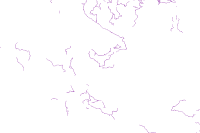

In [16]:
# # Upload as feature layer
# routes_sdf = GeoAccessor.from_geodataframe(routes, inplace=False, column_name='SHAPE')
# routes_fl = routes_sdf.spatial.to_featurelayer(title='State Park Trails',
#                                                          gis=gis,
#                                                          tags='Camping')

#Get feature layer
routes_fl = gis.content.get('a789dc2099c24e659c5829cab5beac2c')
routes_fl

In [17]:
# Create buffers of 1000 meters (0.62 miles)
routes_buffered = use_proximity.create_buffers(routes_fl, distances=[1000], units = 'Meters')

{"cost": 6.478}


In [18]:
routes_map = gis.map()
routes_map.extent = study_area_extent
routes_map.add_layer(routes_buffered)
routes_map.add_layer(routes_fl)
routes_map.add_layer(campgrounds_fl)
routes_map

MapView(layout=Layout(height='400px', width='100%'))

#### Near River

<Item title:"CA Rivers" type:Feature Layer Collection owner:dsc170wi24_44>
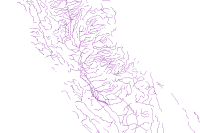

In [19]:
# river_sdf = GeoAccessor.from_geodataframe(river, inplace=False, column_name='SHAPE')
# river_fl = river_sdf.spatial.to_featurelayer(title='CA Rivers',
#                                                          gis=gis,
#                                                          tags='Camping')
river_fl = gis.content.get('d1dc945e8357493cb9219ed3491867fe')
river_fl

In [20]:
# Create buffers of 3000 meters (1.89 miles)
rivers_buffered = use_proximity.create_buffers(river_fl, distances=[3000], units = 'Meters')

{"cost": 1.171}


In [21]:
river_map = gis.map('California, US')
river_map.add_layer(campgrounds_fl)
river_map.add_layer(rivers_buffered)
river_map.add_layer(river_fl)
river_map

MapView(layout=Layout(height='400px', width='100%'))

#### Light Pollution

In [22]:
# Extent and clip
light_pollution_clip = extent_clip(light_pollution)

# Normalize map into 9 bins
light_pollution_n = remap(raster=light_pollution_clip,
                  input_ranges = [0, 0.2,
                                  0.2, 1,
                                  1, 5,
                                  5, 10,
                                  10, 20,
                                  20, 54.0,
                                  54.0, 63.0,
                                  63.0, 72.0,
                                  72.0, 100000],
                  output_values=[9,8,7,6,5,4,3,2,1],  astype='U8')

In [23]:
light_pollution_n_c = colormap(light_pollution_n, colormap=clrmap9)

map_light_n = gis.map()
map_light_n.extent = study_area_extent
map_light_n.add_layer(light_pollution_n_c)
map_light_n.legend=True
map_light_n

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [24]:
# Change imagery layer to feature layer
# light_fl = light_pollution_n.to_features()
# light_fl = gis.content.get('359b115ffc6b41cf9d28ba2fc85b7398')
# light_fl

#### Air Pollution

In [25]:
# Extent and clip
air_clip = extent_clip(air_pollution)

# Normalize
air_n = remap(raster=air_clip,
                  input_ranges=[0,5.75,
                                5.75,6,
                                6,7,
                                7,8,
                                8,9,
                                9,10,
                                10,11,
                                11,12,
                                12,100000],
                  output_values=[9,8,7,6,5,4,3,2,1],  astype='U8')
air_n.compute_histograms(geometry=study_area_geom)

{'histograms': [{'size': 10,
   'min': -0.5,
   'max': 9.5,
   'counts': [0, 0, 1, 1, 8, 11, 26, 22, 7, 19]}]}

In [26]:
# Plot colormap
air_n_c = colormap(air_n, colormap=clrmap9)

map_air_n = gis.map()   
map_air_n.extent = study_area_extent
map_air_n.legend=True
map_air_n.add_layer(air_n_c)
map_air_n

MapView(layout=Layout(height='400px', width='100%'), legend=True)

In [27]:
# Change to feature layer 
#air_fl = air_n.to_features()
#air_fl = gis.content.get('7ba57f788aa94960a0d99199a37b4891')

# air_fl = gis.content.get('a5c244c6241344509635eda832609967')
# air_fl

--------------------------------------------------------------------------------------

## Analysis

***TODO***

Provide a general outline of your analysis (in a markdown), and then document it step by step
as you code the solution. Please make sure that we can reproduce your analysis by running
your notebook. As before, a diagram describing your workflow would be helpful.

Please also reflect on how your actual analysis steps were different compared to your project
proposal - or state that you didn’t deviate from the initial plan.

(a combination of markdown and documented code cells)
(at least 500 words)

In [123]:
import folium

In [28]:
# Filter campgrounds by proximity to routes and rivers
camps_routes_joined = campgrounds_sdf.spatial.join(routes_buffered.query().sdf,how="inner")
camps_rivers_joined = campgrounds_sdf.spatial.join(rivers_buffered.query().sdf,how="inner")
route_filtered_sdf = campgrounds_sdf.loc[campgrounds_sdf['FID'].isin(camps_routes_joined["FID"].unique())]
river_filtered_sdf = campgrounds_sdf.loc[campgrounds_sdf['FID'].isin(camps_rivers_joined["FID"].unique())]

In [124]:
def get_suitable_campsites(data_dict, light_plltn_w, air_plltn_w, river_prox, trail_prox):
    """Returns a list of suitable campsites based on criteria"""
    filtered_df = sd_campgrounds.copy()
    # Filter boolean vars
    for k,v in data_dict.items():
        filtered_df = filtered_df[filtered_df[k] == v]
    
    # Filter by proximity to trail or river
    if river_prox and trail_prox:
        filtered_df = filtered_df.loc[(filtered_df['FID'].isin(camps_rivers_joined["FID"].unique())) & (filtered_df['FID'].isin(camps_routes_joined["FID"].unique()))]
    elif river_prox:
        filtered_df = filtered_df.loc[filtered_df['FID'].isin(camps_rivers_joined["FID"].unique())]
    elif trail_prox:
        filtered_df = filtered_df.loc[filtered_df['FID'].isin(camps_routes_joined["FID"].unique())]
    
    
    # Filter by air pollution / light pollution
    result = light_plltn_w*light_pollution_n + air_plltn_w*air_n
#     result_lyr = result.save(gis=gis)
    
#     # Cut off suitability by approximately 65th percentile
#     mean = result_lyr.layers[0].properties["meanValues"]
#     std = result_lyr.layers[0].properties["stdvValues"]
#     cut_off = stats.norm.ppf(0.65,loc=mean, scale=std)
    result_b = remap(raster=result,
                      input_ranges=[0,7.5, 7.5, 10000],
                      output_values=[1,0],  astype='U8')
    
    # Change to feature layer
    resultb_lyr = result_b.save(gis=gis)
    resultb_fl = resultb_lyr.layers[0].to_features()

    # Find intersection of suitability
    suitable_sdf = resultb_fl.layers[0].query('gridcode=0').sdf
    filtered_df = campgrounds_sdf.spatial.join(suitable_sdf, op='intersects', how='inner')
    
    # Get map
    filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry='SHAPE', crs=3857)
    filtered_gdf = filtered_gdf.to_crs(espg=4326)
    # Create a map centered around San Diego County
    map = folium.Map(zoom_start=8, location=[33.0200, -116.8049])
    for idx, row in filtered_gdf.iterrows():
        popup_text = f"<b>Campground</b>: {row['Campground']}<br><b>Type</b>: {row['TYPE']}<br><b>State Park</b>: {row['UNITNAME']}"
        marker = folium.Marker([row.SHAPE.y, row.SHAPE.x], popup=popup_text)
        map.add_child(marker)
    
    return map
    

In [32]:
%%time
data_dict = {'Horse': False, 'Showers':True}
lyr = get_suitable_campsites(data_dict, 0.5, 0.5, True, True)

{"cost": 1}


CPU times: user 1.43 s, sys: 95.8 ms, total: 1.53 s
Wall time: 3min 7s


--------------------------------------------------------------------------------------

## Results

***TODO***

Describe what you found, and why it is important; illustrate the findings with maps/charts
reflecting your results.

(a combination of markdown and documented code cells)

(200 words)

## Discussion

The discussion should include the following parts:
1) Discuss your findings with respect to the literature sources in section 3. What do the
results mean in the context of what is already known? What is new? Does it validate
what was found in literature? How do your results improve our understanding of the
problem?

2) Of particular importance is a discussion of any trade-offs and decision points that you
had to consider. This may include a discussion of any performance issues, width of
buffers you applied, projections you chose, spatial operations you used, machine
learning techniques, and other issues we discussed in class.
(this can be done as a markdown, at least 200 words)


We explore 3 different methods of filtering: Conventional boolean joins, raster vote weighting, as well as spatial join operations

## Conclusions and Future Work

Did you manage to completely answer your initial research question? If not, what additional
data and additional analysis steps can you think of? Can your approach be extended to other
areas or topics, and use additional datasets? How do you expect the results to be used and by
whom?

(a markdown cell, at least 200 words)
